## Data Sources

We used **three** primary sources for our project. For all sources, we gathered data for the years **2006 - 2016**. Observational unit for study was **Metropolitan Statistical Area (MSA).** An MSA is defined to be a geographical area with high population density.

### 1. FBI Uniform Crime Reporting (UCR) Program ###

We **automated** the extraction murders and man-slaughter data from the FBI database for the years 2006 - 2017.**Table 1** lists the features provided in the FBI database.

<center> ** Table 1: List of Crime Variables from FBI ** </center>

|          Name          |
|:--------------------------------|
| Violent Crime                     |
| Murder + Non-negligent Manslaughter|
| Forcible Rape               |
| Robbery                  |
| Aggravated Assault            |
| Property Crime           |
| Burglary           |
| Larceny-theft                |
| Motor Vehicle Theft                |
| Population of MSA         |
| Population of Largest city within MSA          |

The crime variables listed in Table 1 were available in three separate forms: Number for entire MSA, Number within the largest city of the MSA, and the number across the MSA per 100,000 individuals (a rate).

*URL: https://ucr.fbi.gov/ucr-publications*

### 2. United States Census Bureau (UCSB) ###

We obtained demographic data for each MSA from the USCB.  We used our EDA (Exploratory Data Analysis), intuition, and the provided Glaeser paper to identify the features in scope. **Table 2** list the names, definitions, and table numbers for which we got census data.

<center> ** Table 2: Census Features Pulled for our analysis ** </center>


|          Feature Name          | Feature Definition | USCB Table Number |
|--------------------------------|---|----------------------------------------------------------------------|
| white | % of White people | B02001 
| black | % of Black people | B02001
| asian | % of Asian people | B02001
| unemp_16_ovr | % Unemployed (age 16 years and over) | S2301
| unemp_16_19 | % Unemployed (age 16-19) | S2301
| unemp_female | % Unemployed Female | S2301
| median age| Median Age | S0101
| sex_ratio | Number of Males per 100 females | S0101
| male_pop | % Male Population | S0101
| female_pop | % Female Population | S0101
| pop_15_19 | % of Population age 15-19 | S0101
| pop_20_24 | % of Population age 20-24 | S0101
| male_pop_20_24 | % Male Population age 20-24 | S0101
| married_house | % of Households with married couples | B09005
| female_house | % of Single Households led by female | B09005
| male_house | % of Single Households led by male | B09005
| no_hs_18_24 | % of 18-24 year olds with no high school | S1501
| hs_18_24 | % of 18-24 year olds with high school | S1501
| no_9th_25_ovr | % of age 25 and over with less than 9th grade | S1501
| no_hs_25_ovr | % of age 25 and over with no high school | S1501
| hs_25_ovr | % of age 25 and over with high school | S1501
| gini | Gini Index | B19083
| under_18_pov  | poverty_rate among 18 and under | S1701
| 18_64_pov | poverty_rate among 18-64 years | S1701
| male_pov | povery_rate among males | S1701
| female_pov | poverty_rate among females  | S1701

We selected these variables because data were widely available (by year and by MSA) and we wanted to try to collect a range of economic, gender, racial, and age features to get a diverse array of variables about an MSA.

*URL: https://factfinder.census.gov/*

### 3. Bureau of Economic Analysis (BEA) ###

The data on income from UCSB were mostly missing and thus unusable.  Instead, we looked to the BEA which provided **real per-capita GDP**, that measures an MSA aggregate economic activity.  The reason we chose real per-capita GDP are two-fold. Per-capita GDP is better than GDP for our purposes because it adjusts for population. Otherwise, larger MSA will always have larger GDP due to more people and resources. Secondly, real per capita GDP was chosen to control for inflation. Our GDP measure is in 2005 dollars for all years so that comparisons between years is due to actual changes rather than inflation

*URL: https://www.bea.gov/iTable/iTable.cfm?ReqID=70#reqid=70&step=1&isuri=1&7003=1000&7004=naics&7035=-1&7005=1&7006=xx&7001=21000&7036=-1&7002=2&7090=70&7007=-1&7093=levels*


## Data Integration & Merging

Listed below are the gaps that we've identified in the extracted data, alongside the design decisions we made for re-formatting

**Crime Data (FBI Uniform Crime Reporting Program):**

* Some MSA had crime statistics within multiple cities while the others only had one. We decided to define our city features as those that come from the largest city (by population) so that each MSA had one set of city statistics


* Not all MSA had 100% reporting rate of data. For those MSAs that did not have 100% reporting, an estimated total was reported. We used the estimated total rather than the actual variables so that all of our data represented the entire MSA (either actual or estimated).


* Crime data did not have a numeric ID for MSA. We initially considered using a cross-walk to translate the MSA descriptions to IDs but decided otherwise since IDs changed over time. MSA desciptions were a concatenation of the key cities followed by the state name. There were instances where an MSA was part of multiple states. We also observed that MSA names change over time. For accurate and unique identification, we created a unique **join_key** for each MSA. To create the join key, we extracted the first city name from the MSA description and concantenated it with the state abbreviation (which was also a part of the MSA description). We then used this **join_key along with year to merge the three data sets** to create one complete data frame for subsequent analysis.

**Census Data:**

We created custom tables at the M.S.A level from the census database and extracted the files in Excel format. These files were merged into a census dataframe, which was later joined back to the Crime Dataset

* Around 4% of MSA descriptions differed from what we obtained from the FBI Database. These cases were manually updated.  


In [1]:
import pandas as pd
import urllib
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
Function
---------------
split_MSA

This method takes in a dataframe with MSA and splits into a city_key (largest city)
and state_key. This will help facilitate MSA merging

Returns dataframe with these two additional features
"""
def split_MSA(df):
    df['MSA'] = df['MSA'].str.replace('Metro Area', '')
    # Need to manually fix how this MSA is written
    df.loc[df['MSA'].str.contains("Texarkana"), "MSA"] = "Texarkana, AR-TX"

    #Grab Everything before comma
    df['city_key'] = df['MSA'].str.split(",").str[0]
    # Then grab everything before first hyphen if it has it
    df['city_key'] = df['city_key'].str.split("-").str[0].str.strip()
    # State will be everying after comma 
    df['state_key']=df['MSA'].str.split(",").str[1].str.strip()
    return(df)

"""
Function
--------
append_df

This function appends two dataframes

Parameters:
    input - dataframe to be appended
    output - dataframe to be appended onto
    
Returns a single dataframe 
"""
def append_df(input,output):
    if output.empty:
        output=input.copy()
    else:
        output=pd.concat([output,input])
        output.reset_index(drop='Index',inplace=True)
    return(output)

'''
Function
-----------
var_thresh

This function takes in a dataframe and keeps only those varaibles that have a pct
non-missing that is above that threshold
'''
def var_thresh(df, thresh=0.65):
    return(df.loc[:, pd.notnull(df).sum() > len (df) *thresh])

'''
Function
---------
slim_df

This function takes in a list of variables to keep
on the the given df. It keep the variables + geography
then renames to MSA and drops the first row of variable descriptions
'''
def slim_df(df, var_list):
    var_list.append('GEO.display-label')
    df = df.loc[:, var_list]
    # Get rid of Micro Areas
    df = df.loc[~df['GEO.display-label'].str.contains("Micro Area"), :]
    
    df = df.rename(index=str, columns={'GEO.display-label': 'MSA'})
    df['MSA'] = df["MSA"].astype(str)
    # Drop first row of var descriptions
    df = df.loc[df.MSA != "Geography", :]
    # Split MSA into city-state key
    return(split_MSA(df))

'''
Function
---------
match_crime

This function will take in a dataframe and make changes to MSA
in order to match crime data
'''
def match_crime(df):
    df.loc[df['MSA'].str.contains('Crestview'),'city_key']='Crestview'
    df.loc[df['MSA'].str.contains('Sarasota'),'city_key']='North Port'
    df.loc[df['MSA'].str.contains('Louisville'),'city_key']='Louisville'
    df.loc[df['MSA'].str.contains('Santa Maria'),'city_key']='Santa Maria'
    df.loc[df['MSA'].str.contains('Weirton'),'city_key']='Weirton'
    df.loc[df['MSA'].str.contains('San Germán'),'city_key']='San German'
    df.loc[df['MSA'].str.contains('Mayagüez'),'city_key']='Mayaguez'
    df.loc[df['MSA'].str.contains('Honolulu'),'city_key']='Urban Honolulu'

    #State
    df.loc[df['MSA'].str.contains('Worcester'),'state_key']='MA-CT'
    df.loc[df['MSA'].str.contains('Myrtle Beach'),'state_key']='SC-NC'
    df.loc[df['MSA'].str.contains('Salisbury'),'state_key']='MD-DE'
    df.loc[df['MSA'].str.contains('Weirton'),'state_key']='WV-OH'
    return(df)

'''
Function
--------
get_file_name

Get the appropriate file name giving year and table code

'''
def get_file_name(year, table_code):
    if year == 2006:
        mid = 'EST'
    else:
        mid = '1YR'
    return('ACS_'+str(year)[2:]+"_%s_" %mid + table_code)

'''
Function
--------
convert_to_int

This function takes in a dataframe and list of vars to convert to int
'''
def convert_to_int(df, int_vars):
    df[int_vars] = df[int_vars].astype(int)
    return(df)
'''
Function
----------
create_proportions

This function will take in a list of variables and a single total variable
It then creates proportions by dividing each of the variables in the list by the total
to create a proportion
'''
def create_proportions(df,num_list, total_var):
    df.loc[:, num_list] = df[num_list].apply(lambda x: x / df[total_var])
    del df[total_var]
    return(df)

"""
function
-----------
fbi_url_generator

This function pulls violent crime spreadsheets from FBI UCR website
for a given year

It takes in the year of interest and outputs a url string
"""
def fbi_url_generator(year):
    if 2006 <= year <= 2009:
        return('https://www2.fbi.gov/ucr/cius%i/data/documents/'%year +str(year)[2:]+'tbl06.xls')
    else:
        if 2010 <= year <= 2011:
            end = '/tables/table-6/output.xls'
        elif 2012 <= year <= 2013:
            end = '/tables/6tabledatadecpdf/table-6/output.xls'
        elif 2014 <= year <= 2015:
            if year == 2014:
                mid = 'Table_6_Crime_in_the_United_States_by_Metropolitan_Statistical_Area_2014/output.xls'
            else:
                mid = 'table_6_crime_in_the_united_states_by_metropolitan_statistical_area_%i.xls/output.xls' %year
            end = '/tables/table-6/%s' %mid
        elif year == 2016:
            end ='/tables/table-4/table-4/output.xls' 
        hostname = 'https://ucr.fbi.gov/crime-in-the-u.s/%i/crime-in-the-u.s.-%i' %(year, year)
        return(hostname + end)
    

In [3]:
#####################
# Employment Data
#####################
emp_all = pd.DataFrame()
for year in range(2006, 2017):
    f = get_file_name(2006, 'S2301')
    employ = pd.read_csv("data/employ/%s.csv" %f, encoding='Latin-1')
    
    # Grab Unemployment
    un = [v for v in employ.columns if "HC04" in v and "EST" in v]
    employ = slim_df(employ, un)
    
    employ = employ.loc[:, ["MSA", "city_key", "state_key", 
                          "HC04_EST_VC01", "HC04_EST_VC03",
                         'HC04_EST_VC24']]
    employ['year'] = year
    emp_all = append_df(employ, emp_all) 

# Process Final DataFrame
emp_all = emp_all.sort_values(['city_key', 'state_key', 'year'])
emp_all = match_crime(emp_all)
del emp_all['MSA']
emp_all = emp_all.rename(index=str,
                        columns={'HC04_EST_VC01': 'unemp_16_ovr',
                                'HC04_EST_VC03': 'unemp_16_19',
                                'HC04_EST_VC24': 'unemp_female'})
#emp_all.head()

In [4]:
############
# Age Data
############
age_all = pd.DataFrame()
for year in range(2006, 2017):
    f = get_file_name(year, 'S0101')
    age = pd.read_csv("data/age/%s.csv" %f, encoding='Latin-1')
    age = slim_df(age, [v for v in age.columns if "EST" in v])
    age = age.replace("(X)", np.nan)

    age = age.loc[:, ['MSA','city_key','state_key',
                      'HC01_EST_VC33','HC01_EST_VC34',
                      'HC01_EST_VC01', 'HC02_EST_VC01',
                      'HC03_EST_VC01', 'HC01_EST_VC06',
                      'HC01_EST_VC07', 'HC02_EST_VC07']]
    age['year'] = year
    age_all = append_df(age, age_all) 


# Process Final DataFrame
age_all = age_all.sort_values(['city_key', 'state_key', 'year'])
age_all = age_all.rename(index=str,
                         columns={'HC01_EST_VC33':'median_age',
                                'HC01_EST_VC34': 'sex_ratio',
                                'HC01_EST_VC01': 'total_pop',
                                'HC02_EST_VC01': 'male_pop',
                                'HC03_EST_VC01': 'female_pop',
                                'HC01_EST_VC06': 'pop_15_19',
                                'HC01_EST_VC07': 'pop_20_24',
                                'HC02_EST_VC07': 'male_pop_20_24'})

# Convert to Int and Get Proportions
age_all = convert_to_int(age_all, ['total_pop', 'male_pop', 'female_pop'])
age_all = create_proportions(age_all, ['male_pop', 'female_pop'], 'total_pop')
# Match Crime Data and then get rid of MSA
age_all = match_crime(age_all)
del age_all['MSA']
#age_all.head()

In [5]:
###############
# Income Data
###############
inc_all = pd.DataFrame()
for year in range(2006, 2017):
    f = get_file_name(year, 'B19001F')
    inc = pd.read_csv("data/house_income/%s.csv" %f, encoding='Latin-1')
    # Keep only the estimates
    inc = slim_df(inc, [v for v in inc.columns if "HD01" in v])
    inc['year'] = year
    inc_all = append_df(inc, inc_all) 

# Proccess Final Data Frame
inc_all =  inc_all.rename(index=str,
                          columns={'HD01_VD01':'total',
                                  'HD01_VD02': 'inc_lt10',
                                  'HD01_VD03': 'inc_10_15',
                                  'HD01_VD04': 'inc_15_19',
                                  'HD01_VD05': 'inc_20_24',
                                  'HD01_VD06': 'inc_25_29',
                                  'HD01_VD07': 'inc_30_34',
                                  'HD01_VD08': 'inc_35_39',
                                  'HD01_VD09': 'inc_40_44',
                                  'HD01_VD10': 'inc_45_49',
                                  'HD01_VD11': 'inc_50_59',
                                  'HD01_VD12': 'inc_60_74',
                                  'HD01_VD13':'inc_75_99',
                                  'HD01_VD14':'inc_100_124',
                                  'HD01_VD15':'inc_125_149',
                                  'HD01_VD16':'inc_150_199',
                                  'HD01_VD17':'inc_gt_200'})

numeric_vars =  [v for v in inc_all.columns if "inc" in v]
inc_all = convert_to_int(inc_all, numeric_vars)
inc_all['total'] = inc_all['total'].astype(int)
# Get propotion of each imcome bracket by dividing by total
inc_all = create_proportions(inc_all, numeric_vars, "total")
# Match Crime data and Get rid of MSA
inc_all = match_crime(inc_all)
del inc_all['MSA']
#inc_all.head()

In [6]:
###############
# GINI INDEX
###############
gini_all = pd.DataFrame()
for year in range(2006, 2017):
    f = get_file_name(year, 'B19083')
    gini = pd.read_csv("data/gini/%s.csv" %f, encoding='Latin-1')
    # Don't need micro areas
    gini = slim_df(gini, ["HD01_VD01"])
    gini['year'] = year
    gini_all = append_df(gini, gini_all) 

# Clean Final Dataframes
gini_all = gini_all.rename(index=str,
                           columns={"HD01_VD01":"gini"})
gini_all['gini'] = gini_all['gini'].astype(float)
gini_all = match_crime(gini_all)
del gini_all['MSA']
#gini_all.head()

In [7]:
#################
# Poverty Data
#################
pov_all = pd.DataFrame()
for year in range(2006, 2017):
    f = get_file_name(year, 'S1701')
    pov = pd.read_csv("data/poverty/%s.csv" %f, encoding='Latin-1')
    pov = slim_df(pov, ['HC03_EST_VC03', 'HC03_EST_VC05',
                       'HC03_EST_VC08', 'HC03_EST_VC09'])
    pov['year'] = year
    pov_all = append_df(pov, pov_all)
# Clean Final DataFrame
pov_all = pov_all.rename(index=str,
                        columns={'HC03_EST_VC03': 'under_18_pov',
                                'HC03_EST_VC05':'18_64_pov',
                                'HC03_EST_VC08':'male_pov',
                                'HC03_EST_VC09':'female_pov'})
pov_all = match_crime(pov_all)
del pov_all['MSA']
#pov_all.head()

In [8]:
#################################
# Head of Household Information
#################################
house_all = pd.DataFrame()
for year in range(2006, 2017):
    f = get_file_name(year, 'B09005')
    house = pd.read_csv("data/house_head/%s.csv" %f, encoding='Latin-1')
    house = slim_df(house, [v for v in house.columns if "HD01" in v])
    house = house.loc[:, ["MSA", "city_key", "state_key",
                         "HD01_VD01", "HD01_VD03", "HD01_VD05",
                         "HD01_VD06"]]
    house['year'] = year
    house_all = append_df(house, house_all) 

# Clean Entire DataFrame
house_all = house_all.rename(index=str,
                             columns={'HD01_VD01': 'total',
                                     'HD01_VD03': 'married_house',
                                     'HD01_VD05': 'female_house',
                                     'HD01_VD06': 'male_house'})

house_all = convert_to_int(house_all,
                       ['total', 'married_house', 'female_house', 'male_house'])
house_all = create_proportions(house_all, ['married_house', 'female_house', 'male_house'], 'total')
house_all = match_crime(house_all)
del house_all['MSA']
#house_all.head()

In [9]:
#################
# Education Data
#################
edu_all = pd.DataFrame()
for year in range(2006,2017):
    f = get_file_name(year, 'S1501')
    edu = pd.read_csv("data/education/%s.csv" %f, encoding='Latin-1')
    if 2015 <= year <= 2016:
        edu = slim_df(edu, ['HC02_EST_VC03', 'HC02_EST_VC04', 'HC02_EST_VC09','HC02_EST_VC10', 'HC02_EST_VC11'])
    elif 2010 <= year <= 2014:
        edu = slim_df(edu,['HC01_EST_VC02', 'HC01_EST_VC03', 'HC01_EST_VC08','HC01_EST_VC09', 'HC01_EST_VC10'])
    else:
        edu = slim_df(edu, ['HC01_EST_VC02', 'HC01_EST_VC03', 'HC01_EST_VC07','HC01_EST_VC08', 'HC01_EST_VC09'])
    
    edu['year'] = year
    edu.columns=['no_hs_18_24','hs_18_24','no_9th_25_ovr','no_hs_25_ovr','hs_25_ovr','MSA','city_key','state_key','year']
    edu_all = append_df(edu, edu_all)

#Trim Final Dataframe
edu_all = match_crime(edu_all)
del edu_all['MSA']
#edu_all.head()


In [10]:
############
# Race Data
############
race_all = pd.DataFrame()
for year in range(2006, 2017):
    f = get_file_name(year, 'B02001')
    race = pd.read_csv("data/race/%s.csv" %f, encoding='Latin-1')
    race = slim_df(race, [v for v in race.columns if "HD01" in v])
    race = race.loc[:, ['MSA', 'city_key', 'state_key',
                       'HD01_VD01','HD01_VD02',
                       'HD01_VD03', 'HD01_VD05']]
    
    race['year'] = year
    race_all = append_df(race, race_all)

# Proccess Final Data Frame
race_all =  race_all.rename(index=str,
                            columns={'HD01_VD01':'total',
                                    'HD01_VD02': 'white',
                                    'HD01_VD03': 'black',
                                    'HD01_VD05': 'asian'})

race_all = convert_to_int(race_all, ['total', 'white','black','asian'] )
race_all = create_proportions(race_all, ['white', 'black', 'asian'], 'total')
# Match Crime Data
race_all = match_crime(race_all)
del race_all['MSA']
#race_all.head()

In [11]:
# Bring Everything Together
census_df = race_all.copy()

merge_df = lambda df: census_df.merge(df,
                                     how='outer',
                                     on=['city_key','state_key','year'],
                                     indicator=True)

str_list = ['Employment', 'Age', 'Head of House','Education', 'Gini', 'Poverty']
df_list = [emp_all, age_all, house_all, edu_all, gini_all, pov_all]

for i, df in enumerate(df_list):
    census_df = merge_df(df)
    #print("%s Merge Stats" %str_list[i])
    #print(census_df['_merge'].value_counts())
    del census_df['_merge']
    
'''

Household had ones where it looks like there may be mismatches but code below checked it

Code to check merges
names = census_df.loc[census_df._merge != "both", ['city_key', 'state_key', '_merge']]
names = names.sort_values['city_key', 'state_key']
names = names.drop_duplicates()
print(names.shape[0])
names.head(50)
'''

'\n\nHousehold had ones where it looks like there may be mismatches but code below checked it\n\nCode to check merges\nnames = census_df.loc[census_df._merge != "both", [\'city_key\', \'state_key\', \'_merge\']]\nnames = names.sort_values[\'city_key\', \'state_key\']\nnames = names.drop_duplicates()\nprint(names.shape[0])\nnames.head(50)\n'

In [12]:
#####################
# Bring in BEA Data
#####################
bea_gdp = pd.read_csv("data/BEA_real_GDP_pc.csv",skiprows=[0,1,2], header=1)
del bea_gdp['Fips']
bea_gdp= bea_gdp.iloc[1:, :].rename(index=str, columns={"Area": 'MSA'})
bea_gdp = pd.melt(bea_gdp, id_vars=["MSA"], var_name='year', value_name='real_pc_gdp')
bea_gdp = bea_gdp.loc[bea_gdp.MSA.notnull(), :]
bea_gdp['year'] = bea_gdp['year'].astype(int)
bea_gdp = bea_gdp.loc[bea_gdp.year >= 2006, :]

# Get rid of MSA in paranthesis
bea_gdp['MSA'] = bea_gdp['MSA'].str.replace(r"\(.*\)","")
bea_gdp = split_MSA(bea_gdp)
# Need to manually fix this one so it will merge
bea_gdp.loc[bea_gdp.city_key.str.contains("Louisville"), 'city_key'] = 'Louisville'

del bea_gdp['MSA']

In [13]:
census_df = merge_df(bea_gdp)
del census_df["_merge"]

In [14]:
# Check to make sure that there were no typos
#names = census_df.loc[census_df._merge != "both", ['city_key', 'state_key', '_merge']]
#names = names.drop_duplicates()
#print(names.shape[0])
#del census_df["_merge"]

In [28]:
#census_df.head()
for d in census_df.columns:
    print(d)


city_key
state_key
white
black
asian
year
unemp_16_ovr
unemp_16_19
unemp_female
median_age
sex_ratio
male_pop
female_pop
pop_15_19
pop_20_24
male_pop_20_24
married_house
female_house
male_house
no_hs_18_24
hs_18_24
no_9th_25_ovr
no_hs_25_ovr
hs_25_ovr
gini
under_18_pov
18_64_pov
male_pov
female_pov
real_pc_gdp


In [16]:
# THIS CODE ONLY NEEDS TO BE RUN ONCE TO BRING IN ALL OF THE EXCEL FILES
version='Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36'
test=urllib.request.URLopener()
test.addheader('User-Agent',version)
for year in range(2006, 2017):
    #print("Pulling: %i" %year)
    test.retrieve(url=fbi_url_generator(year),filename='crime_%i.xls' %year)


In [17]:
df_allyears = pd.DataFrame()
for year in range(2006, 2017):
    df = pd.read_excel("crime_%i.xls" %year,skiprows=[0,1],header=1)

    #######
    # NOTE - misc column has msa population, city population and estimate percentage
    ######
    df=df.iloc[:,0:12] 
    df.columns=['MSA', 'counties','misc', 'violent_crime','mur_mans', 'rape', 'robbery',
                'assault', 'property', 'burglary', 'larceny','mv_theft']
    
    df['counties'].replace(' ',np.nan, inplace=True)

    # Drop footnotes
    footnotes = df['MSA'].str[0].str.isdigit().fillna(False)
    df = df.loc[~footnotes, :]
    
    #Drop blank rows
    df = df.dropna(how='all')

    # Get rid of numbers in MSA
    df['MSA'] = df['MSA'].str.replace('\d+', '')
    # Set empty columns to NaN for MSA
    df['MSA'] = df['MSA'].replace(' ', np.nan, regex=False)
    
    # Sometimes city  names get put in MSA column
    # Messes up carry forward
    df.loc[df['MSA'].str.contains("City of").fillna(False), "MSA"] = np.nan

    # Carry MSA name forward to fill in for all cells
    df.loc[:,'MSA'] = df.loc[:, 'MSA'].fillna(method='ffill')

    ##############
    # POPULATION - grab population and fill in for all MSA
    ##############
    pop_row = df.counties.isnull()
    pop = df.loc[pop_row, ["MSA", 'misc']]
    pop = pop.rename(index=str, columns={'misc': 'msa_pop'})
    
    # Merge population back in
    df = df.loc[~pop_row, :]
    df = df.merge(pop, how='outer', on='MSA')

    ################
    # Descriptions - don't need county descriptions 
    ################
    df = df.loc[df.counties.str.contains("Includes") == False, :]


    ###########################################
    # GOING LONG TO WIDE FOR CRIME VARIABLES
    ###########################################
    crime_vars = ['violent_crime','mur_mans', 'rape', 'robbery',
                  'assault', 'property', 'burglary', 'larceny','mv_theft']

    #########
    # CITIES
    #########
    city_vars = ['MSA', 'counties', 'misc'] + crime_vars
    # Split data Frame
    cities = df.counties.str.contains("City")
    city_df = df.loc[cities, city_vars]
    city_df = city_df.rename(index=str, columns={'misc': 'city_pop'})
    
    # Grab largest city for each MSA and merge back on
    city_df = city_df.sort_values(['MSA','city_pop'], ascending=False)
    large_city = city_df.groupby('MSA').first().reset_index()

    # Rename crime variables to denote city only crime 
    large_city.columns = ['MSA', 'counties', 'city_pop'] + ['city_' + i for i in crime_vars]
    large_city = large_city.rename(index=str, columns={'counties':'largest_city'})
    # Get rid of "City of"
    large_city.loc[:,'largest_city'] = large_city.loc[:, 'largest_city'].str.replace('City of','')
    
    # Merge back to main dataframe
    df = df.loc[~cities, ]
    df = df.merge(large_city, how='outer', on='MSA')

    ###############
    # CRIME RATE
    ###############
    rates = df.counties.str.contains("Rate per")
    rate_vars = ['MSA'] + crime_vars
    rates_df = df.loc[rates, rate_vars]
    rates_df.columns = ['MSA'] + ['rate_' + i for i in crime_vars]

    df = df.loc[~rates, :]
    df = df.merge(rates_df, how='outer', on='MSA')

    ########################
    # MSA-WIDE CRIME STATS
    ########################

    # If the entire MSA reported then there is just one row of numbers
    # If the entire MSA did not report, then there are two rows
            # first row is areas that reported
            # second report is an estimated total
    # We are going to grab the estimates total so our data
    # reflects all areas for all MSA

    # Create Flag for those that do not have complete coverage
    # and are thus estimates
    mins = df.groupby('MSA').misc.min().reset_index()
    mins.columns = ['MSA', 'min_coverage']
    df = df.merge(mins, how='outer', on='MSA')
    df['estimate'] = 0
    df.loc[df.min_coverage < 1, 'estimate'] = 1
    del df['min_coverage']

    # Now only keeping rows with coverage = 1
    # will either be all area or the estimate for all area
    df = df.loc[df.misc == 1, :]

    # Now no longer need coverage or whether its estimate or not
    del df['misc']
    del df['counties']
    
    df['year'] = year
    
    # Append to existing Frame
    df_allyears = append_df(df, df_allyears)

In [18]:
df_allyears = df_allyears.sort_values(["MSA", 'year'])

In [19]:

#Generate the city
df_allyears['city_key'] = df_allyears['MSA'].str.replace(' M.S.A.','').str.split(",").str[0]
df_allyears['city_key'] = df_allyears['city_key'].str.split("-").str[0].str.strip()
df_allyears['state_key']=df_allyears['MSA'].str.replace(' M.S.A.','').str.split(",").str[1].str.strip().str.replace(' M.S.A','')

In [20]:
##Cleanse Crime Data
df_allyears=df_allyears[~df_allyears['MSA'].str.contains(' M.D.')]
df_allyears.loc[df_allyears['state_key']=='Puerto Rico','state_key']='PR'
df_allyears.loc[df_allyears['MSA'].str.contains('Texarkana'),'state_key']='AR-TX'
df_allyears.loc[df_allyears['city_key']=='Worcester','state_key']='MA-CT'
df_allyears.loc[df_allyears['city_key']=='Steubenville','city_key']='Weirton'
df_allyears.loc[df_allyears['city_key']=='Steubenville','state_key']='WV-OH'
df_allyears.loc[df_allyears['city_key']=='Honolulu','city_key']='Urban Honolulu'
df_allyears.loc[df_allyears['MSA'].str.contains('Scranton'),'city_key']='Scranton'
df_allyears.loc[df_allyears['MSA'].str.contains('Sarasota'),'city_key']='North Port'
df_allyears.loc[df_allyears['MSA'].str.contains('Santa Maria'),'city_key']='Santa Maria'
df_allyears.loc[df_allyears['MSA'].str.contains('Salisbury'),'state_key']='MD-DE'
df_allyears.loc[df_allyears['MSA'].str.contains('Sacramento'),'city_key']='Sacramento'
df_allyears.loc[df_allyears['MSA'].str.contains('Myrtle Beach'),'state_key']='SC-NC'
df_allyears.loc[df_allyears['MSA'].str.contains('Louisville'),'city_key']='Louisville'
df_allyears.loc[df_allyears['MSA'].str.contains('Homosassa'),'city_key']='Homosassa Springs'
df_allyears.loc[df_allyears['MSA'].str.contains('Crestview'),'city_key']='Crestview'

In [21]:
#Merge Crime and census data
final_df = df_allyears.merge(census_df, how='left', on=['city_key','state_key','year'])

In [22]:
# Function to convert to float otherwise set to NaN
def f(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [23]:
# Look at final Cleaning of data-types
float_cols = final_df.columns.difference(["MSA", "city_key", "state_key","year", "largest_city"])
for v in float_cols:
    try:
        final_df[v] = final_df[v].astype(float)
    except:
        continue
# Assault Rate Needs to be fixed
# One Value is missing
final_df.loc[final_df.rate_assault == " ", 'rate_assault'] = np.nan
final_df["rate_assault"] = final_df["rate_assault"].astype(float)

#### PUERTO RICO CELL

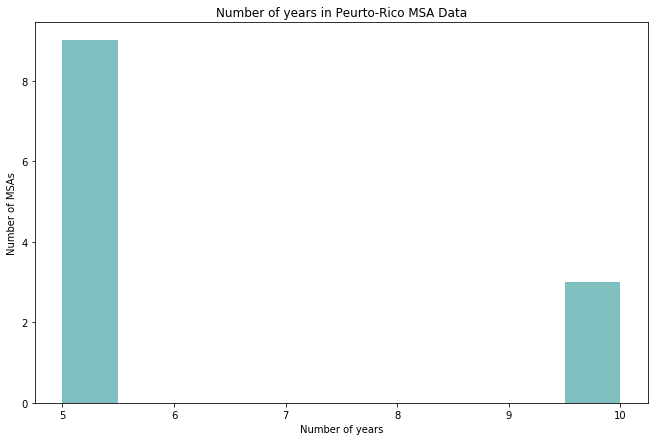

In [24]:
#Find the number of years within each MSA in Puerto Rico
pr_msa=final_df[final_df['state_key'].str.contains("PR")].groupby('MSA').count().iloc[:,31]
fig, ax = plt.subplots(1,1, figsize=(11,7))
ax.hist(pr_msa, color='teal',alpha=0.5)
ax.set_title('Number of years in Peurto-Rico MSA Data')
ax.set_xlabel('Number of years')
ax.set_ylabel('Number of MSAs');

In [25]:
#Exclude any PR data
final_df = final_df.loc[~final_df['state_key'].str.contains("PR"), :]

In [26]:
#Create a join key
final_df['join_key'] = final_df['city_key'].str.cat(final_df['state_key'],sep='-')
#Add columns for OHE
final_df['year_ohe'] = final_df['year']
final_df['state_ohe'] = final_df['state_key']
final_df['join_ohe'] = final_df['join_key']
#One hot encode join key, state key and year
final_df = pd.get_dummies(final_df,prefix='year',columns=['year_ohe']) #Not dropping one column since year has missing values
final_df = pd.get_dummies(final_df,prefix=['MSA','state'],columns=['join_ohe','state_ohe'],drop_first=True)

In [27]:
final_df.to_json('output/final.json')